# Non-Linear Models

In [33]:
import numpy as np , pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib .pyplot import subplots
import statsmodels .api as sm
from ISLP import load_data
from ISLP.models import (summarize ,
poly ,
ModelSpec as MS)
from statsmodels .stats.anova import anova_lm

from pygam import (s as s_gam ,
l as l_gam ,
f as f_gam ,
LinearGAM ,
LogisticGAM )
from ISLP. transforms import (BSpline ,
NaturalSpline )
from ISLP.models import bs , ns
from ISLP.pygam import (approx_lam ,
degrees_of_freedom ,
plot as plot_gam ,
anova as anova_gam )

In [34]:
data=pd.read_csv("Data/aircraft_price_Engineered.csv")
data.columns

Index(['price', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span',
       'range'],
      dtype='object')

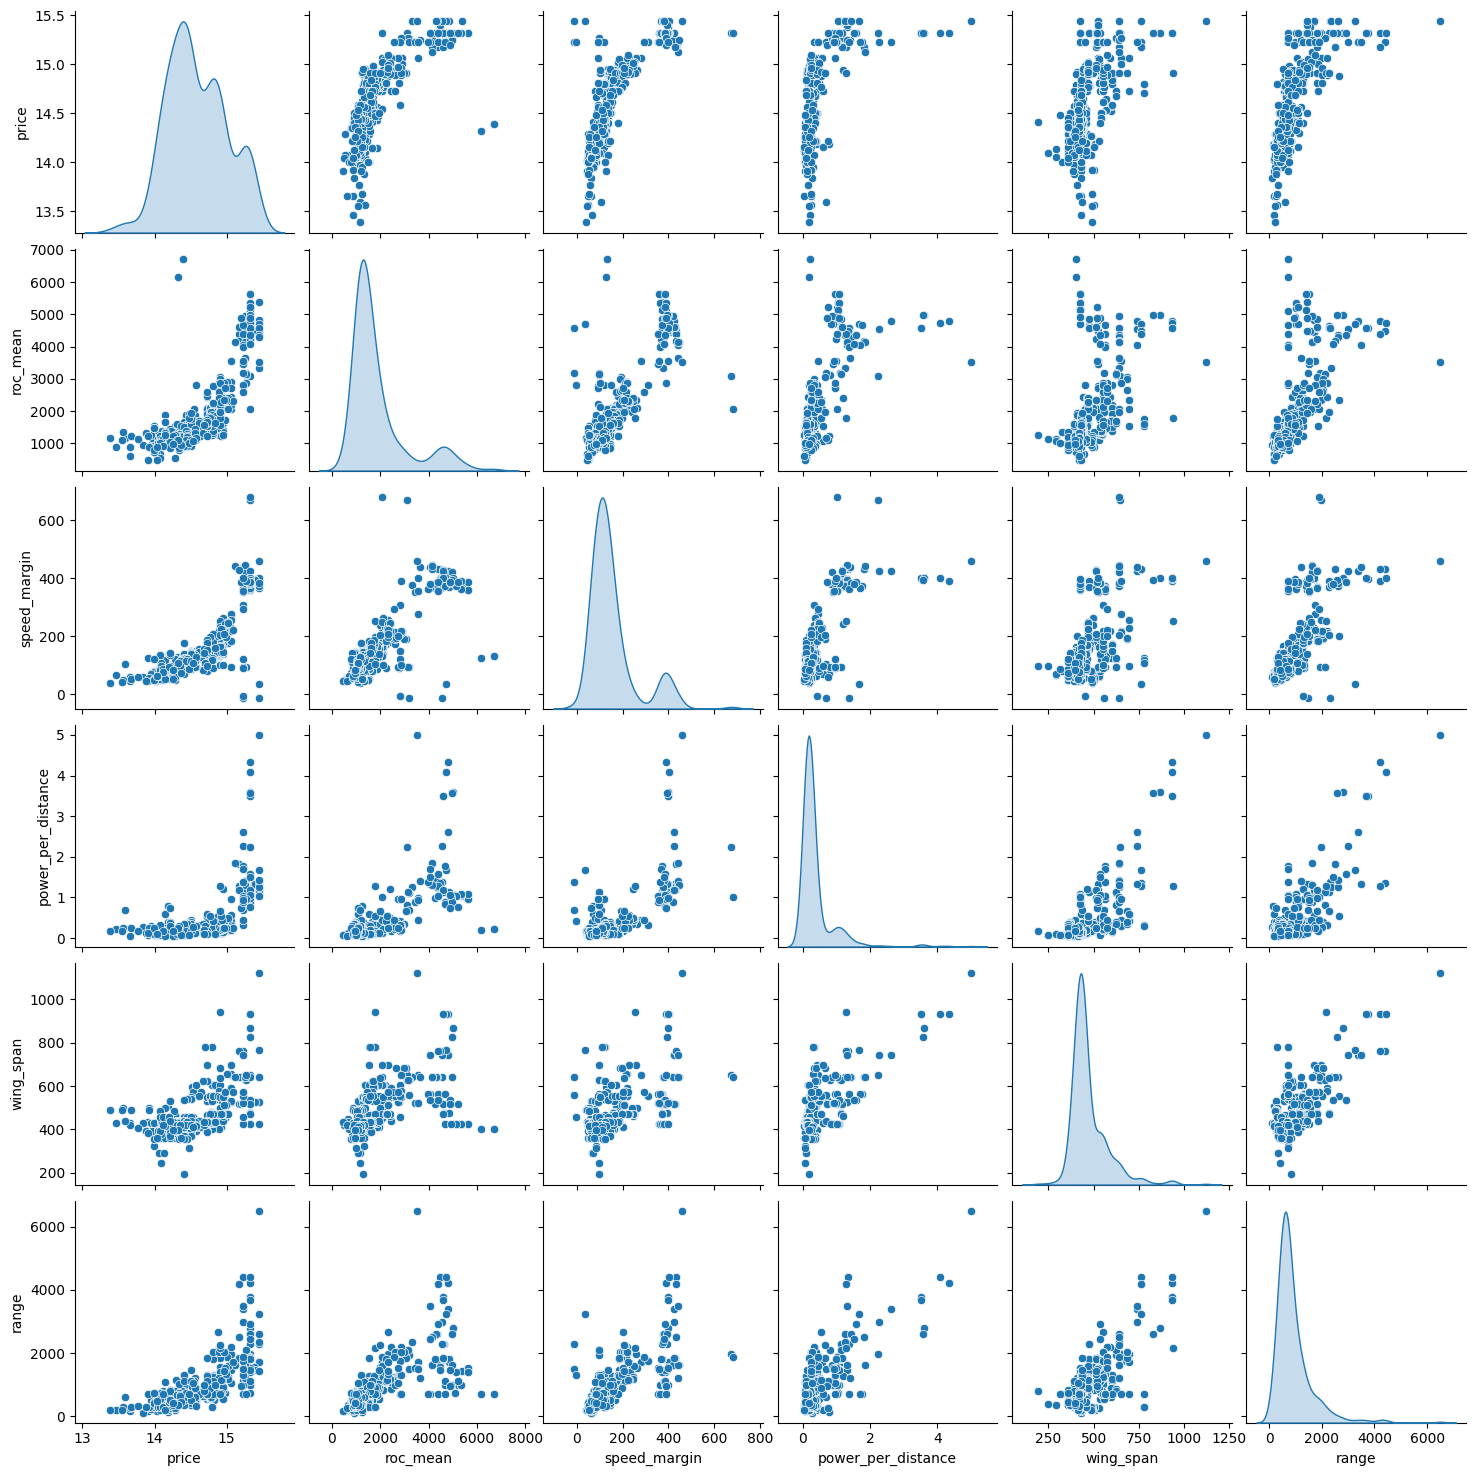

In [35]:
price = data['price']
roc_mean = data['roc_mean']
speed_margin = data['speed_margin']
power_per_distance = data['power_per_distance']
wing_span = data['wing_span']
range = data['range']

#pairplot

sns.pairplot(data, diag_kind='kde', height=2.5)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     269.6
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          1.64e-139
Time:                        17:05:35   Log-Likelihood:                -388.38
No. Observations:                 507   AIC:                             788.8
Df Residuals:                     501   BIC:                             814.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -1.2840      0.296     

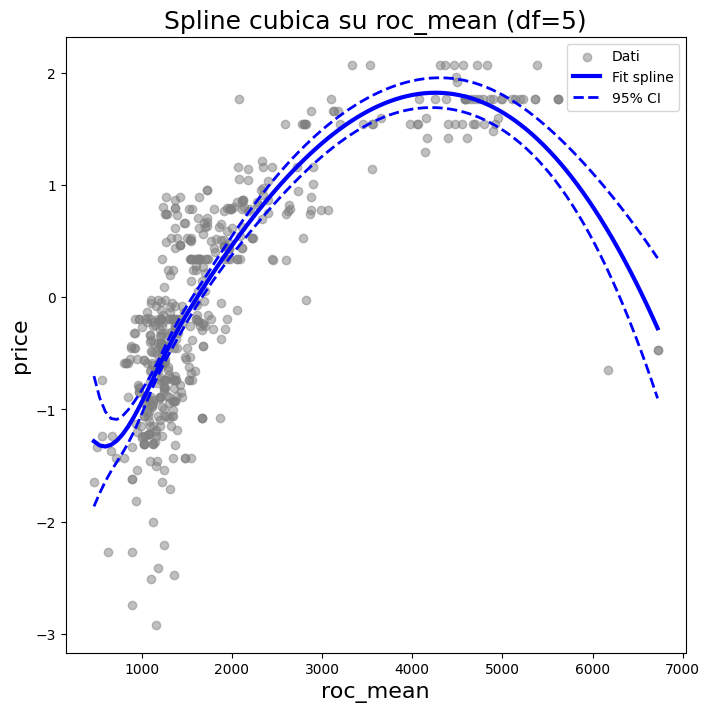

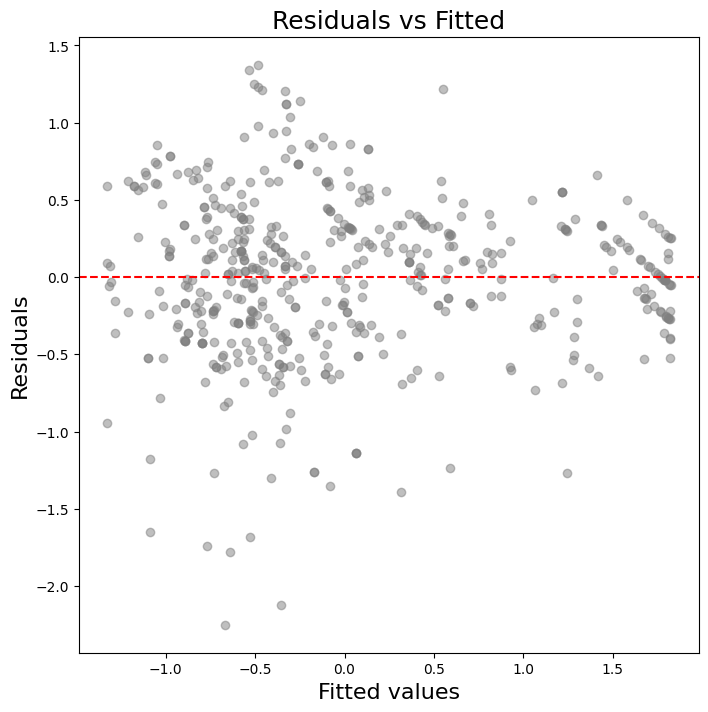

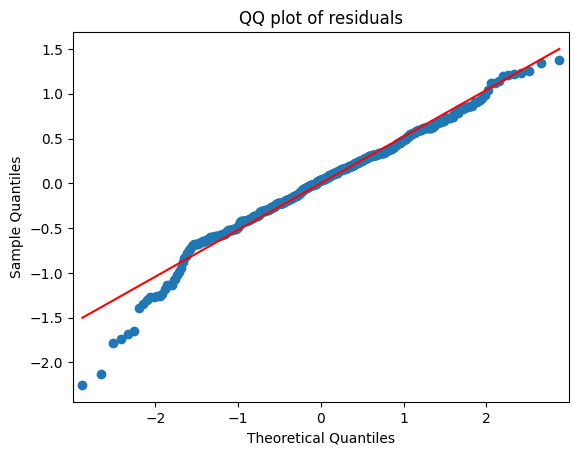

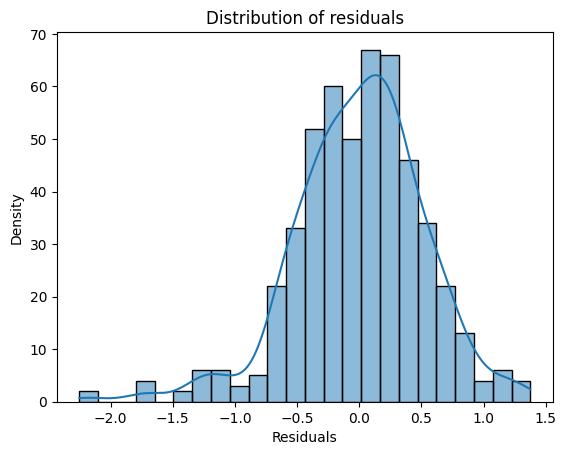

In [36]:

# Specifica del modello spline su roc_mean
# qui df=5 gradi di libertà → cubic spline con nodi scelti automaticamente
bs_roc = MS([ bs("roc_mean", df=5, name="bs(roc_mean)") ])

# 4) Fit del modello e stampa sommario
X_bs = bs_roc.fit_transform(data)       # calcola la matrice delle basi spline
M_bs = sm.OLS(y, X_bs).fit()
summarize(M_bs)
print(M_bs.summary())
#stampa MSE
print("MSE: ", M_bs.mse_resid)
#essendo price in logaritmo, voglio calcolare il MSE in scala originale
#MSE originale = e^(2*MSE) - 1
print("MSE originale: ", np.exp(2*M_bs.mse_resid) - 1)
#RMSE
print("RMSE: ", np.sqrt(M_bs.mse_resid))
# —————————————————————————————

# —————————————————————————————
# 5) Creazione di una griglia per roc_mean e predizione
roc_grid = np.linspace(data["roc_mean"].min(), data["roc_mean"].max(), 100)
grid_df  = pd.DataFrame({"roc_mean": roc_grid})
Xg_bs    = bs_roc.transform(grid_df)              # trasformazione sui nuovi punti
preds    = M_bs.get_prediction(Xg_bs)             
bands    = preds.conf_int(alpha=0.05)             # intervalli di confidenza 95%
# —————————————————————————————

# —————————————————————————————
# 6) Plot dei dati, del fit e dei 95% CI
fig, ax = subplots(figsize=(8,8))
ax.scatter(data["roc_mean"], y, facecolor="gray", alpha=0.5, label="Dati")
ax.plot (roc_grid, preds.predicted_mean,   "b-",  linewidth=3, label="Fit spline")
ax.plot (roc_grid, bands[:,0],             "b--", linewidth=2, label="95% CI")
ax.plot (roc_grid, bands[:,1],             "b--", linewidth=2)
ax.set_xlabel("roc_mean", fontsize=16)
ax.set_ylabel("price",    fontsize=16)
ax.set_title ("Spline cubica su roc_mean (df=5)", fontsize=18)
ax.legend()

#residuals vs fitted
residuals = M_bs.resid
fitted = M_bs.fittedvalues
fig, ax = subplots(figsize=(8,8))
ax.scatter(fitted, residuals, facecolor="gray", alpha=0.5)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel("Fitted values", fontsize=16)
ax.set_ylabel("Residuals", fontsize=16)
ax.set_title("Residuals vs Fitted", fontsize=18)
plt.show()
#QQ plot
sm.qqplot(M_bs.resid, line='s')
plt.title("QQ plot of residuals")
plt.show()
#plot distibution of residuals
sns.histplot(M_bs.resid, kde=True)
plt.title("Distribution of residuals")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.show()

In [37]:
# modello lineare semplice
X_lin = sm.add_constant(data[["roc_mean"]])
m_lin = sm.OLS(y, X_lin).fit()

# modello spline (già definito come M_bs)
anova = anova_lm(m_lin, M_bs)
print(anova)

   df_resid         ssr  df_diff    ss_diff          F        Pr(>F)
0     505.0  219.633515      0.0        NaN        NaN           NaN
1     501.0  137.376067      4.0  82.257449  74.996655  8.474448e-50


R^2 CV ottimo: 0.7379579638816944
Miglior modello: Pipeline(steps=[('splinetransformer',
                 SplineTransformer(include_bias=False, n_knots=8)),
                ('linearregression', LinearRegression())])
Miglior n_knots: 8
RMSE CV ottimo: 0.21543229977924055


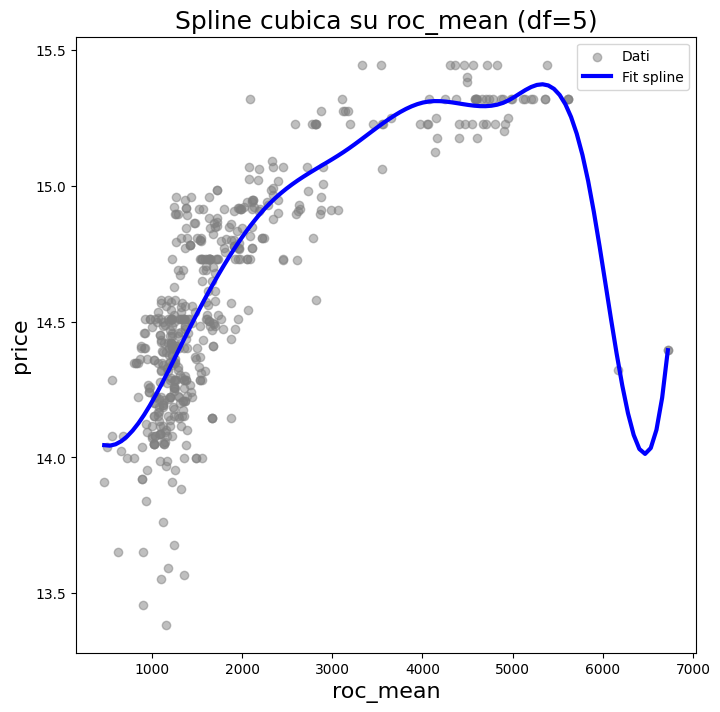

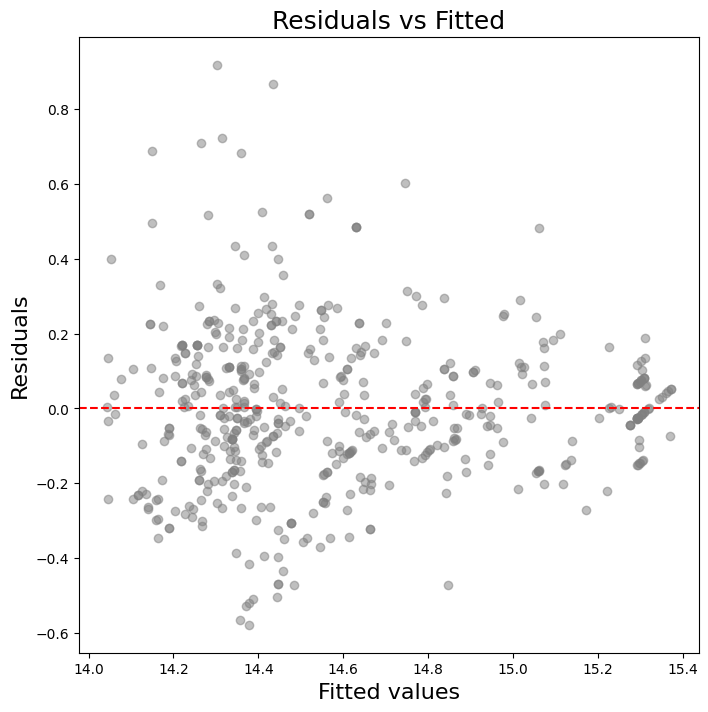

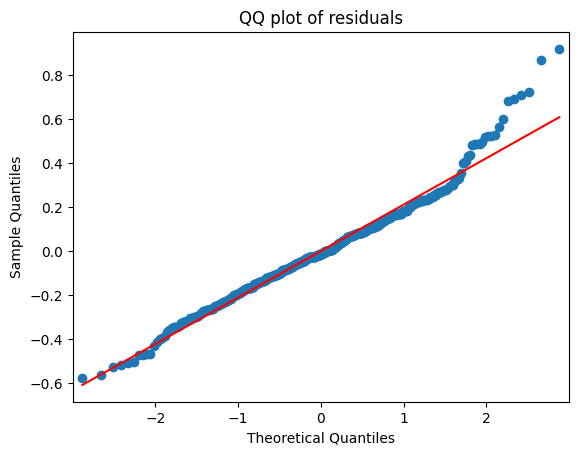

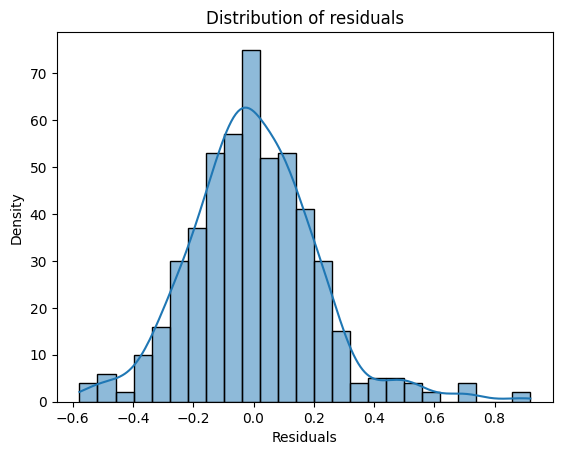

In [38]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np

# Pipeline con spline su roc_mean → LR
pipe = make_pipeline(
    SplineTransformer(degree=3, include_bias=False),
    LinearRegression()
)

# Grid di possibili numeri di nodi (df = n_knots + degree − 1)
param_grid = {
    "splinetransformer__n_knots": [4, 5, 6, 7, 8]
}

cv = KFold(5, shuffle=True, random_state=0)
search = GridSearchCV(pipe, param_grid, cv=cv,
                      scoring="neg_mean_squared_error")
search.fit(data[["roc_mean"]], data["price"])

#print Rsquared
print("R^2 CV ottimo:", search.best_estimator_.score(data[["roc_mean"]], data["price"]))
#stampa i parametri ottimi
print("Miglior modello:", search.best_estimator_)

print("Miglior n_knots:", search.best_params_["splinetransformer__n_knots"])
print("RMSE CV ottimo:", np.sqrt(-search.best_score_))

#plotting
fig, ax = subplots(figsize=(8,8))
ax.scatter(data["roc_mean"], data["price"], facecolor="gray", alpha=0.5, label="Dati")
ax.plot(roc_grid, search.predict(grid_df), "b-", linewidth=3, label="Fit spline")
ax.set_xlabel("roc_mean", fontsize=16)
ax.set_ylabel("price", fontsize=16)
ax.set_title("Spline cubica su roc_mean (df=5)", fontsize=18)
ax.legend()
plt.show()

#residuals vs fitted
residuals = search.predict(data[["roc_mean"]]) - data["price"]
fitted = search.predict(data[["roc_mean"]])
fig, ax = subplots(figsize=(8,8))
ax.scatter(fitted, residuals, facecolor="gray", alpha=0.5)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel("Fitted values", fontsize=16)
ax.set_ylabel("Residuals", fontsize=16)
ax.set_title("Residuals vs Fitted", fontsize=18)
plt.show()

#QQ plot
sm.qqplot(residuals, line='s')
plt.title("QQ plot of residuals")
plt.show()

#plot distibution of residuals
sns.histplot(residuals, kde=True)
plt.title("Distribution of residuals")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.show()




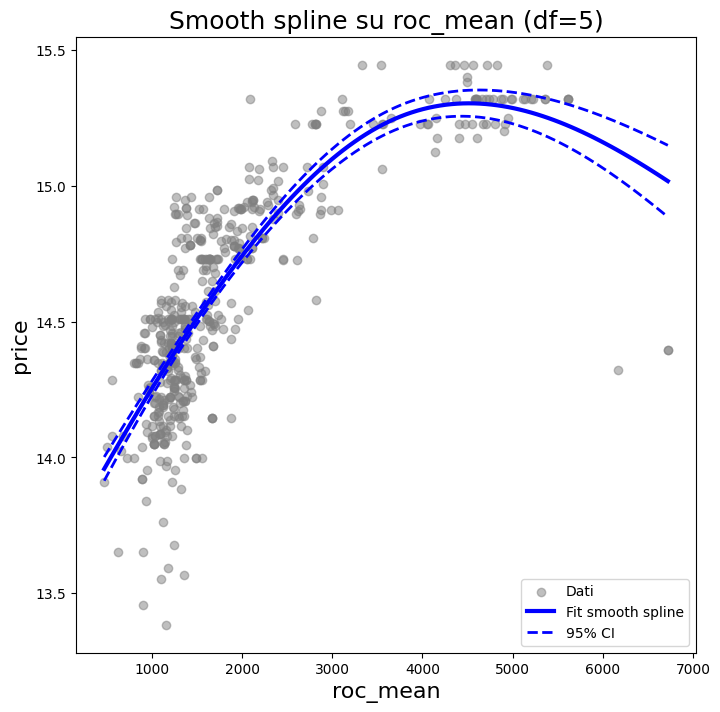

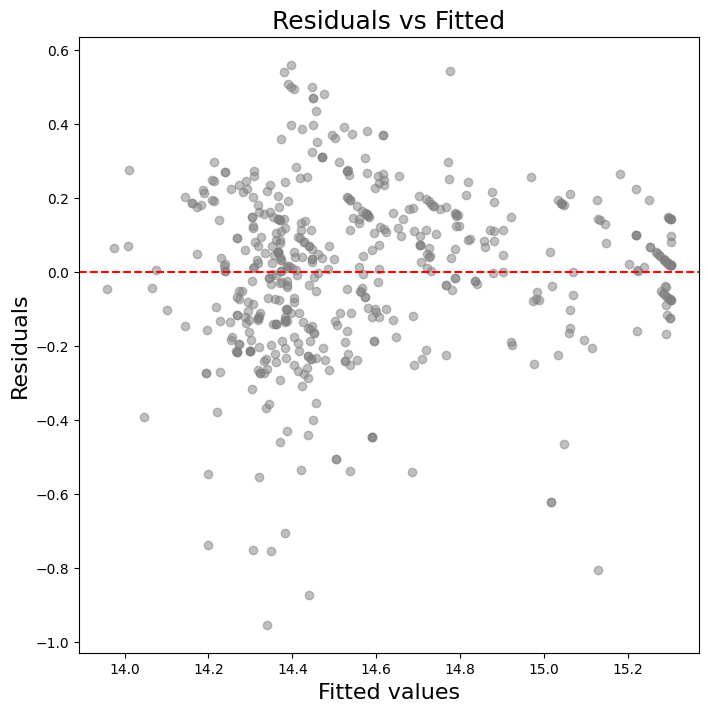

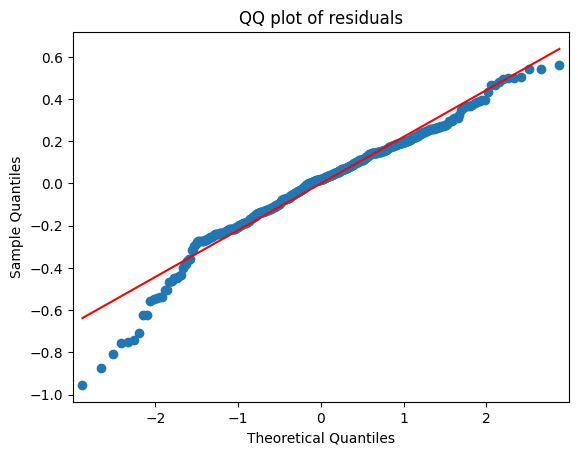

In [43]:
#Smooth spline
# 1) Fit del modello GAM con smooth spline su roc_mean
from pygam import s


gam = LinearGAM(s(0, n_splines=5)).fit(data[["roc_mean"]], data["price"])
# 2) Predizione su griglia
preds = gam.predict(grid_df)
# 3) Intervalli di confidenza
bands = gam.confidence_intervals(grid_df, width=0.95)
# 4) Plot dei dati, del fit e dei 95% CI
fig, ax = subplots(figsize=(8,8))
ax.scatter(data["roc_mean"], data["price"], facecolor="gray", alpha=0.5, label="Dati")
ax.plot(roc_grid, preds, "b-", linewidth=3, label="Fit smooth spline")
ax.plot(roc_grid, bands[:,0], "b--", linewidth=2, label="95% CI")
ax.plot(roc_grid, bands[:,1], "b--", linewidth=2)
ax.set_xlabel("roc_mean", fontsize=16)
ax.set_ylabel("price", fontsize=16)
ax.set_title("Smooth spline su roc_mean (df=5)", fontsize=18)
ax.legend()
plt.show()

#residuals vs fitted
residuals = gam.deviance_residuals(data[["roc_mean"]], data["price"])
fitted = gam.predict(data[["roc_mean"]])
fig, ax = subplots(figsize=(8,8))
ax.scatter(fitted, residuals, facecolor="gray", alpha=0.5)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel("Fitted values", fontsize=16)
ax.set_ylabel("Residuals", fontsize=16)
ax.set_title("Residuals vs Fitted", fontsize=18)
plt.show()

#QQ plot
sm.qqplot(residuals, line='s')
plt.title("QQ plot of residuals")
plt.show()


## Generalized Additive Model 

In [ ]:
X_age = np.asarray(age).reshape (( -1 ,1))
gam = LinearGAM (s_gam (0, lam =0.6))
gam.fit(X_age , y)



In [ ]:
fig , ax = subplots (figsize =(8 ,8))
ax.scatter(age , y, facecolor ='gray ', alpha =0.5)
for lam in np. logspace (-2, 6, 5):
gam = LinearGAM (s_gam (0, lam=lam)).fit(X_age , y)
ax.plot(age_grid ,
gam.predict( age_grid),
label='{:.1e}'.format(lam),
linewidth =3)
ax. set_xlabel ('Age ', fontsize =20)
ax. set_ylabel ('Wage ', fontsize =20);
ax.legend(title='$\ lambda$ ');